In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [10]:

# Chargement des données d'entraînement et de test
train_data = pd.read_csv('data/modifie/trainFinal.csv', parse_dates = ['date'])  
test_data = pd.read_csv("data/modifie/testFinal.csv", parse_dates = ['date'])



In [11]:
# Suppression des colonnes inutiles
data = train_data.drop(['Unnamed: 0', 'id','dateStoreNbr','transactions'], axis=1)
test = test_data.drop(['Unnamed: 0', 'id', 'dateCityKey', 'dateStateKey','dateStoreNbr','transactions'], axis=1)

data['Year'] = data['date'].dt.year
data['Month'] = data['date'].dt.month
data['Day'] = data['date'].dt.day
data['Weekday'] = data['date'].dt.weekday 

data['YearCat'] = data['Year'].astype('category').cat.codes
data['MonthCat'] = data['Month'].astype('category').cat.codes
data['DayCat'] = data['Day'].astype('category').cat.codes
data['WeekdayCat'] = data['Weekday'].astype('category').cat.codes



test['Year'] = test['date'].dt.year
test['Month'] = test['date'].dt.month
test['Day'] = test['date'].dt.day
test['Weekday'] = test['date'].dt.weekday

test['YearCat'] = test['Year'].astype('category').cat.codes
test['MonthCat'] = test['Month'].astype('category').cat.codes
test['DayCat'] = test['Day'].astype('category').cat.codes
test['WeekdayCat'] = test['Weekday'].astype('category').cat.codes



data['familyCat'] = data.family.astype('category').cat.codes
data['cityCat'] = data.city.astype('category').cat.codes
data['stateCat'] = data.state.astype('category').cat.codes

test['familyCat'] = test.family.astype('category').cat.codes
test['cityCat'] = test.city.astype('category').cat.codes
test['stateCat'] = test.state.astype('category').cat.codes


data = data.drop(['family','city','state'], axis=1)
test = test.drop(['family','city','state'], axis=1)

data = data.drop(['Year', 'Month', 'Day', 'Weekday','date'], axis=1)
test = test.drop(['Year', 'Month', 'Day', 'Weekday','date'], axis=1)

In [ ]:
# Prétraitement des données
scaler = MinMaxScaler()
data['sales_scaled'] = scaler.fit_transform(data['sales'].values.reshape(-1, 1))
data = data.drop('sales', axis=1)


Epoch 1/20

4220/4220 - 126s - loss: 7.5827e-05 - val_loss: 7.3189e-05 - 126s/epoch - 30ms/step
Epoch 2/20
4220/4220 - 117s - loss: 7.3911e-05 - val_loss: 7.0545e-05 - 117s/epoch - 28ms/step
Epoch 3/20
4220/4220 - 115s - loss: 3.4041e-05 - val_loss: 1.6334e-05 - 115s/epoch - 27ms/step
Epoch 4/20
4220/4220 - 115s - loss: 1.7384e-05 - val_loss: 1.3740e-05 - 115s/epoch - 27ms/step
Epoch 5/20
4220/4220 - 116s - loss: 1.5061e-05 - val_loss: 1.2546e-05 - 116s/epoch - 28ms/step
Epoch 6/20
4220/4220 - 114s - loss: 1.4014e-05 - val_loss: 1.1103e-05 - 114s/epoch - 27ms/step
Epoch 7/20
4220/4220 - 114s - loss: 1.3440e-05 - val_loss: 1.0795e-05 - 114s/epoch - 27ms/step
Epoch 8/20
4220/4220 - 114s - loss: 1.3189e-05 - val_loss: 1.0919e-05 - 114s/epoch - 27ms/step
Epoch 9/20
4220/4220 - 114s - loss: 1.2831e-05 - val_loss: 1.0651e-05 - 114s/epoch - 27ms/step
Epoch 10/20
4220/4220 - 113s - loss: 1.2615e-05 - val_loss: 1.1420e-05 - 113s/epoch - 27ms/step
Epoch 11/20
4220/4220 - 113s - loss: 1.2340e-05

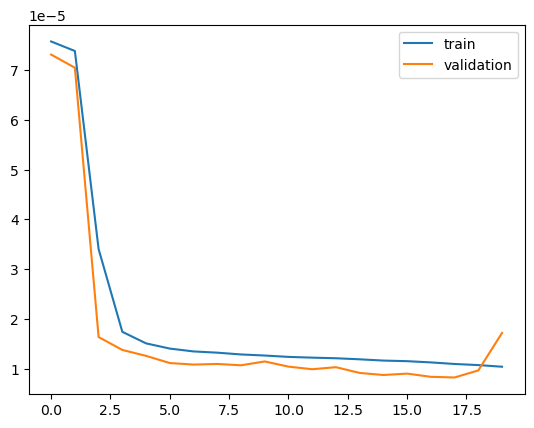

Loss sur les données de test : 1.7962378478841856e-05
18756/18756 [==============================] - 76s 4ms/step


In [12]:
# Prétraitement des données
scaler = MinMaxScaler()
data['sales_scaled'] = scaler.fit_transform(data['sales'].values.reshape(-1, 1))
data = data.drop('sales', axis=1)

# Création des séquences temporelles
def create_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        target = data[i + sequence_length]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 10  # Ajustez selon votre choix
X, y = create_sequences(data['sales_scaled'].values, sequence_length)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construction du modèle GRU
model = Sequential()
model.add(GRU(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dense(units=1))
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_split=0.1, verbose=2)

# Afficher la courbe d'apprentissage
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Évaluation du modèle sur les données de test
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss sur les données de test : {loss}')

# Prédiction sur les données de test
predictions = model.predict(X_test)

# Inverse transform pour obtenir les prédictions dans l'échelle d'origine
predictions_original_scale = scaler.inverse_transform(predictions)




In [13]:

# Remplacer les valeurs négatives par zéro
predictions_original_scale[predictions_original_scale < 0] = 0

# Afficher les prédictions
print("Prédictions sur les données de test :")
print(predictions_original_scale)

# Afficher les vraies valeurs (non échelonnées) correspondantes aux prédictions
true_values = scaler.inverse_transform(y_test.reshape(-1, 1))
print("Vraies valeurs sur les données de test :")
print(true_values)

# Calculer et afficher le score du modèle sur les données de test
mse = mean_squared_error(true_values, predictions_original_scale)
print(f"Mean Squared Error sur les données de test : {mse}")
# Calculer RMSE
rmse = np.sqrt(mean_squared_error(true_values, predictions_original_scale))
print(f"Root Mean Squared Error (RMSE) sur les données de test : {rmse}")

# Calculer MAE
mae = mean_absolute_error(true_values, predictions_original_scale)
print(f"Mean Absolute Error (MAE) sur les données de test : {mae}")

# Calculer R²
r2 = r2_score(true_values, predictions_original_scale)
print(f"Coefficient de détermination (R²) sur les données de test : {r2}")


Prédictions sur les données de test :
[[  0.      ]
 [157.91354 ]
 [  0.      ]
 ...
 [  5.111955]
 [ 13.874211]
 [  0.      ]]
Vraies valeurs sur les données de test :
[[ 24.]
 [271.]
 [  4.]
 ...
 [  0.]
 [  0.]
 [  0.]]
Mean Squared Error sur les données de test : 265458.8378850275
Root Mean Squared Error (RMSE) sur les données de test : 515.2269770548002
Mean Absolute Error (MAE) sur les données de test : 156.18879984139107
Coefficient de détermination (R²) sur les données de test : 0.7798066291638925


In [30]:
display(test)
test.info()


,store_nbr,onpromotion,flagHoliday,dcoilwtico,YearCat,MonthCat,DayCat,WeekdayCat,familyCat,cityCat,stateCat
0,1,0,0,46.80,0,0,0,2,0,18,12
1,1,0,0,46.80,0,0,0,2,1,18,12
2,1,2,0,46.80,0,0,0,2,2,18,12
3,1,20,0,46.80,0,0,0,2,3,18,12
4,1,0,0,46.80,0,0,0,2,4,18,12
...,...,...,...,...,...,...,...,...,...,...,...
28507,9,1,0,47.26,0,0,15,3,28,18,12
28508,9,0,0,47.26,0,0,15,3,29,18,12
28509,9,1,0,47.26,0,0,15,3,30,18,12
28510,9,9,0,47.26,0,0,15,3,31,18,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   store_nbr    28512 non-null  int64  
 1   onpromotion  28512 non-null  int64  
 2   flagHoliday  28512 non-null  int64  
 3   dcoilwtico   28512 non-null  float64
 4   YearCat      28512 non-null  int8   
 5   MonthCat     28512 non-null  int8   
 6   DayCat       28512 non-null  int8   
 7   WeekdayCat   28512 non-null  int8   
 8   familyCat    28512 non-null  int8   
 9   cityCat      28512 non-null  int8   
 10  stateCat     28512 non-null  int8   
dtypes: float64(1), int64(3), int8(7)
memory usage: 1.1 MB


In [37]:
display(data)
data.info()


,store_nbr,onpromotion,flagHoliday,dcoilwtico,YearCat,MonthCat,DayCat,WeekdayCat,familyCat,cityCat,stateCat,sales_scaled
0,1,0,1,93.12,0,0,0,1,0,18,12,0.000000
1,1,0,1,93.12,0,0,0,1,1,18,12,0.000000
2,1,0,1,93.12,0,0,0,1,2,18,12,0.000000
3,1,0,1,93.12,0,0,0,1,3,18,12,0.000000
4,1,0,1,93.12,0,0,0,1,4,18,12,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,9,0,0,47.57,4,7,14,1,28,18,12,0.003513
3000884,9,1,0,47.57,4,7,14,1,29,18,12,0.001239
3000885,9,148,0,47.57,4,7,14,1,30,18,12,0.019402
3000886,9,8,0,47.57,4,7,14,1,31,18,12,0.000970


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   store_nbr     int64  
 1   onpromotion   int64  
 2   flagHoliday   int64  
 3   dcoilwtico    float64
 4   YearCat       int8   
 5   MonthCat      int8   
 6   DayCat        int8   
 7   WeekdayCat    int8   
 8   familyCat     int8   
 9   cityCat       int8   
 10  stateCat      int8   
 11  sales_scaled  float64
dtypes: float64(2), int64(3), int8(7)
memory usage: 134.5 MB


TEST


In [83]:
test2 = test.copy()
test2['sales'] = 0.0
display(test2)
test2.info()


,store_nbr,onpromotion,flagHoliday,dcoilwtico,YearCat,MonthCat,DayCat,WeekdayCat,familyCat,cityCat,stateCat,sales
0,1,0,0,46.80,0,0,0,2,0,18,12,0.0
1,1,0,0,46.80,0,0,0,2,1,18,12,0.0
2,1,2,0,46.80,0,0,0,2,2,18,12,0.0
3,1,20,0,46.80,0,0,0,2,3,18,12,0.0
4,1,0,0,46.80,0,0,0,2,4,18,12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
28507,9,1,0,47.26,0,0,15,3,28,18,12,0.0
28508,9,0,0,47.26,0,0,15,3,29,18,12,0.0
28509,9,1,0,47.26,0,0,15,3,30,18,12,0.0
28510,9,9,0,47.26,0,0,15,3,31,18,12,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   store_nbr    28512 non-null  int64  
 1   onpromotion  28512 non-null  int64  
 2   flagHoliday  28512 non-null  int64  
 3   dcoilwtico   28512 non-null  float64
 4   YearCat      28512 non-null  int8   
 5   MonthCat     28512 non-null  int8   
 6   DayCat       28512 non-null  int8   
 7   WeekdayCat   28512 non-null  int8   
 8   familyCat    28512 non-null  int8   
 9   cityCat      28512 non-null  int8   
 10  stateCat     28512 non-null  int8   
 11  sales        28512 non-null  float64
dtypes: float64(2), int64(3), int8(7)
memory usage: 1.3 MB


In [85]:
# Charger les nouvelles données sans la variable à prédire (sales)
# Supposons que vous ayez un DataFrame 'new_data' avec des colonnes similaires à celles que vous avez utilisées pour l'entraînement

# Prétraitement des nouvelles données
test2['sales_scaled'] = scaler.transform(test2['sales'].values.reshape(-1, 1))
new_data = test2.drop('sales', axis=1)

# Création des séquences temporelles pour les nouvelles données
X_new, _ = create_sequences(new_data['sales_scaled'].values, sequence_length)

# Prédiction sur les nouvelles données
new_predictions = model.predict(X_new)

# Inverse transform pour obtenir les prédictions dans l'échelle d'origine
new_predictions_original_scale = scaler.inverse_transform(new_predictions)

# Les prédictions pour les nouvelles données sont stockées dans new_predictions_original_scale
# Vous pouvez les utiliser selon vos besoins


TypeError: object of type 'numpy.float64' has no len()

In [ ]:

# Remplacer les valeurs négatives par zéro
predictions_test_original_scale[predictions_test_original_scale < 0] = 0

# Afficher les prédictions
print("Prédictions sur les données de test :")
print(predictions_test_original_scale)

# Afficher les vraies valeurs (non échelonnées) correspondantes aux prédictions
true_values_test = scaler.inverse_transform(y_test.reshape(-1, 1))
print("Vraies valeurs sur les données de test :")
print(true_values)

# Calculer et afficher le score du modèle sur les données de test
mse_test = mean_squared_error(true_values, predictions_test_original_scale)
print(f"Mean Squared Error sur les données de test : {mse_test}")
# Calculer RMSE
rmse_test = np.sqrt(mean_squared_error(true_values, predictions_test_original_scale))
print(f"Root Mean Squared Error (RMSE) sur les données de test : {rmse_test}")

# Calculer MAE
mae_test = mean_absolute_error(true_values, predictions_test_original_scale)
print(f"Mean Absolute Error (MAE) sur les données de test : {mae_test}")

# Calculer R²
r2_test = r2_score(true_values, predictions_test_original_scale)
print(f"Coefficient de détermination (R²) sur les données de test : {r2_test}")


In [ ]:
data['sales_scaled'] = scaler.fit_transform(data['sales'].values.reshape(-1, 1))
